In [1]:
#!/usr/bin/env python                                                                       
'''
25/11/07

Compute energy conversion terms from online diagnostics

=> OK for version dev_SPNA (tag = SPNA-run-(2018-2022))

One issue is that "hdiff" is merged with "hmix" for XIOS outputs, but it was not removed
from "adv". That is why advective terms below are computed using: "adv" - "hmix".
This is OK away from the sponges because there is no explicit mixing ("hmix" was 0 
before adding "hdiff"). In the sponges the budget is then wrong because "hmix" is removed 
(we do "hmix" + "adv" - "hmix") but the hmix/hdiff terms can still be separated by residual.

This has been corrected in the following versions and thus the "adv" terms will already
be "adv - hdiff". No need to remove "hmix".


'''                                                                                         
######################
#import useful modules
######################

import os,sys

####################|

sys.path.append("/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/") 

from Modules import *
#from Modules_gula import *

%matplotlib inline
####################

The mean kinetic energy of the flow is $${\rm KE}=  \frac{1}{2}  (\overline{u^2}+ \overline{v^2}).$$ It is the sum of the kinetic energy of the mean flow, $${\rm MKE}=  \frac{1}{2}  (\overline{u}^2+ \overline{v}^2),$$ and the eddy kinetic energy  $${\rm EKE}=  \frac{1}{2}  (\overline{u^{\prime 2}}+ \overline{v^{\prime 2}}),$$ where the overbar denotes a time average, and the prime denotes fluctuations relative to the time average.

The equation for the kinetic energy of the flow is: 
$$
\frac{1}{2} \frac{\partial u_i^2}{\partial t}  = -  u_j \frac{\partial \frac{1}{2}   u_i^{2}  }{\partial x_j} - \frac{u_i}{\rho_0} \frac{\partial P}{\partial x_i}+  \underbrace{\mathcal{V}_i   u_i}_{{\rm Vertical\,mixing}} + \underbrace{\mathcal{D}_i  u_i}_{{\rm Horizontal\,diffusion}} + \underbrace{\mathcal{S}_i  u_i}_{{\rm sources/sinks}}
$$


The equation for the kinetic energy of the mean flow is: 
$$
\begin{aligned}
\overline{u}_i \overline{\frac{\partial u_i }{\partial{\rm t}} }  = -  \underbrace{ \frac{ \partial \left( \frac{1}{2} \overline{u}_j  \overline{u}_i^{2} +  \frac{1}{\rho_0} \overline{u}_j \overline{p} \right)  }{\partial x_j} }_{{\rm Boundary\, Transport}} -  \underbrace{ \overline{u_i} \frac{\partial \overline{u_j^{\prime} u_i^{\prime}}}{\partial x_j}}_{{\rm EKE \rightarrow MKE}}  +    \underbrace{\overline{w} \overline{b }}_{{\rm MPE \rightarrow MKE}}  + \underbrace{\overline{\mathcal{V}_i}    \overline{u_i}}_{{\rm Vertical\,mixing}}+ \underbrace{\overline{\mathcal{D}_i}    \overline{u_i}}_{{\rm Horizontal\,diffusion}}+ \underbrace{\overline{\mathcal{S}_i}    \overline{u_i}}_{{\rm sources/sinks}},
\end{aligned}.\\
$$

and the equation for the eddy kinetic energy is:
$$
\begin{aligned}
\overline{u_i^{\prime}\frac{\partial{ {u_i^{\prime}}}}{\partial{\rm t}}} = -  \underbrace{\frac{\partial \left( \frac{1}{2} \overline{u_j}\,\overline{u_i^{\prime 2}} + \frac{1}{2} \overline{u_j^{\prime} u_i^{\prime 2}}  +\frac{1}{\rho_0} \overline{u_j^{\prime} p^{\prime}} \right) }{\partial x_j}}_{{\rm Boundary\, Transport}}  - 
\underbrace{\overline{u_j^{\prime} u_i^{\prime}} \frac{\partial\overline{u_i}}{\partial x_j}}_{{\rm MKE \rightarrow EKE}} +   \underbrace{\overline{w^{\prime} b^{\prime} }}_{{\rm EPE \rightarrow EKE}} + \underbrace{\overline{\mathcal{V}^{\prime}_i    u^{\prime}_i}}_{{\rm Vertical\,mixing}}+ \underbrace{\overline{\mathcal{D}^{\prime}_i    u^{\prime}_i}}_{{\rm Horizontal\,diffusion}}+ \underbrace{\overline{\mathcal{S}^{\prime}_i    u^{\prime}_i}}_{{\rm sources/sinks}}
\end{aligned}.\\
$$

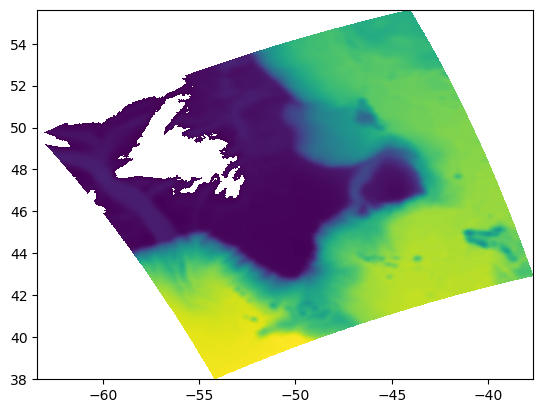

In [2]:
############################################################

mysimul = 'SPNA_1d'; time=1096
coordinates= ' [1000,1500,1500,2000,[1,300,1]] '

simul = load(simul = mysimul + '_avg' + coordinates +format(time), output=False)

####

[y1,y2,x1,x2]=simul.coord[0:4]
season = 0

fifig = './Figures/' + mysimul
save_terms = False

############################################################

# Check domain
simul.mask[simul.mask==0] = np.nan
plt.pcolormesh(simul.x,simul.y, simul.topo * simul.mask)


We load below mean variables ($\overline{u}$, $\overline{v}$, etc.), momentum terms ($\overline{\frac{\partial u_i }{\partial{\rm t}} }$, etc.), kinetic energy terms ($\overline{\frac{1}{2} \frac{\partial u_i^2}{\partial t}}$, etc. ), and eddy terms ($\overline{uv}$, etc.):

In [3]:
############################################################
# Files we need:
foldermean = '/net/libra/local/tmp/1/gula/ROMS/Simulations/CROSSROADS/SPNA/OUT/'

mytime = '2018-01'

# mean avg file with u,v,w
meanfile_avg = foldermean + mysimul + '_aver_' + mytime + '.mean.nc'

# mean diaM avg file
meanfile_M = foldermean + mysimul + '_M_' + mytime + '.mean.nc'

# mean ek avg file
meanfile_ke = foldermean + mysimul + '_KE_' + mytime + '.mean.nc'

# mean eddy avg file
meanfile_eddy = foldermean + mysimul + '_EDDY_' + mytime + '.mean.nc'


####

if os.path.exists(meanfile_avg) and os.path.exists(meanfile_M) and os.path.exists(meanfile_ke) and os.path.exists(meanfile_eddy):
    print("All files exist.")
else:
    print("Some files not found.")


All files exist.


The overall strategy is to compute MKE terms as a product of mean variables ($ \overline{u}_i$) and mean momentum terms ($\overline{\frac{\partial u_i }{\partial{\rm t}} }$) : $$\rm{mke\_rate} =- \overline{u}_i \overline{\frac{\partial u_i }{\partial{\rm t}} } $$

and the EKE terms as differences between energy terms and MKE terms: $$\rm{eke\_rate} = -\overline{u_i^{\prime}\frac{\partial{ {u_i^{\prime}}}}{\partial{\rm t}}} = -\underbrace{\overline{u_i \frac{\partial u_i }{\partial{\rm t}} }}_{\rm{ke\_rate}}  + \underbrace{\overline{u}_i \overline{\frac{\partial u_i }{\partial{\rm t}} }}_{\rm{mke\_rate}}  $$

But some of the terms are further decomposed using eddy terms.

In [4]:

############################################################
# terms to compute
'''
# for MKE equation:

mke_rate = mke_adv + mke_prsgrd + eke_mke + mpe_mke + mke_vmix + mke_hdiff

# for EKE equation:

eke_rate = eke_adv1 + eke_adv2 + eke_prsgrd + mke_eke + epe_eke + eke_vmix + eke_hdiff


+ hrs, vrs 
+ eke_wind, eke_drag (a faire)

'''

coef_dxdy = simul.pm*simul.pn*1e4*simul.mask
coef = 1e4*simul.mask

[z_r,z_w] = tools.get_depths(simul)



########################

def get_var(whichterm, meanfile, grid='r'):
    '''compute term for mke equation using mean momentum term and mean velocity'''
    
    if grid=='u':
        var = tools.u2rho(ionetcdf.get(meanfile, whichterm, simul, time=0, y1=y1, y2=y2, x1=x1, x2=x2-1))
    elif grid=='v':
        var = tools.v2rho(ionetcdf.get(meanfile, whichterm, simul, time=0, y1=y1, y2=y2-1, x1=x1, x2=x2))
    else:
        var = ionetcdf.get(meanfile, whichterm, simul, time=0, y1=y1, y2=y2, x1=x1, x2=x2)

    return var


########################

def get_M_term(whichterm):
    '''compute term for mke equation using mean momentum term and mean velocity'''

    # Mean momentum terms (same grid)
    u_term = get_var(f'u_{whichterm}', meanfile_M, grid='u')

    # Vertical integration
    # dz = z_w[:, :, 1:] - z_w[:, :, :-1]
    m = tools.nanbnd(np.nansum(u_term, axis=2), 2)

    return m


########################

def mke_term(whichterm):
    '''compute term for mke equation using mean momentum term and mean velocity'''
    
    # Mean velocity components at rho-points
    u_mean = get_var('u', meanfile_avg, grid='u')
    v_mean = get_var('v', meanfile_avg, grid='v')

    # Mean momentum terms (same grid)
    u_term = get_var(f'u_{whichterm}', meanfile_M, grid='u')
    v_term = get_var(f'v_{whichterm}', meanfile_M, grid='v')

    # Dot product (momentum ⋅ velocity)
    mke = u_term * u_mean + v_term * v_mean

    # Vertical integration
    # dz = z_w[:, :, 1:] - z_w[:, :, :-1]
    mke = tools.nanbnd(np.nansum(mke, axis=2), 2)

    return mke

########################

def ke_term(whichterm):
    """
    Load the kinetic energy tendency for the given term.

    and integrate vertically
    """
    
    # Get variable from file
    ke_data = ionetcdf.get(meanfile_ke, whichterm, simul, time=0, y1=y1, y2=y2, x1=x1, x2=x2)

    # Compute layer thickness difference
    #dz = z_w[:, :, 1:] - z_w[:, :, :-1]

    # Sum vertically (axis=2), then apply boundary fix and scaling
    ke_sum = np.nansum(ke_data, axis=2)
    ke_rate = tools.nanbnd(ke_sum, 2) * coef_dxdy
    
    return ke_rate


## mke_rate, eke_rate

$$\rm{mke\_rate} = \overline{u}_i \overline{\frac{\partial u_i }{\partial{\rm t}} } $$

$$\rm{eke\_rate} = \overline{u_i^{\prime}\frac{\partial{ {u_i^{\prime}}}}{\partial{\rm t}}} = \underbrace{\overline{u_i \frac{\partial u_i }{\partial{\rm t}} }}_{\rm{ke\_rate}}  - \underbrace{\overline{u}_i \overline{\frac{\partial u_i }{\partial{\rm t}} }}_{\rm{mke\_rate}}  $$

In [5]:
#############
# 1. mke_rate
#############

mke_rate = mke_term('rate') * coef

#############
# 2. eke_rate
#############

ke_rate = ke_term('ke_rate')

eke_rate = ke_rate - mke_rate

#plot.p2(mke_rate.T,eke_rate.T,sym=1,coef=0.1)

## mke_adv, eke_mke 


$$\rm{mke\_adv} = - \frac{ \partial \left( \frac{1}{2} \overline{u}_j  \overline{u}_i^{2}  \right)  }{\partial x_j} $$

$$\rm{eke\_mke} = - \overline{u_i} \frac{\partial \overline{u_j^{\prime} u_i^{\prime}}}{\partial x_j}= -\underbrace{\overline{ u_j} \overline{\frac{\partial \frac{1}{2}   u_i^{2} }{\partial x_j} }}_{\rm{ }}  +\underbrace{\frac{ \partial \left( \frac{1}{2} \overline{u}_j  \overline{u}_i^{2}  \right)  }{\partial x_j}}_{\rm{mke\_adv}}  $$

In [6]:
#############
# 3. mke_adv, eke_mke
#############

try:
    mke_adv = np.load('./data_files_py/' + 'mke_adv_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    eke_mke = np.load('./data_files_py/' + 'eke_mke_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    print('load mke_adv,eke_mke')
except:
    print('compute mke_adv,eke_mke')
    ###
    eke_mke = mke_term('adv')  - mke_term('hmix')
    ###
    umean = get_var('u', meanfile_avg, grid='u')
    vmean = get_var('v', meanfile_avg, grid='v')
    
    try:
        wmean = get_var('w', meanfile_avg)
        print('load wmean from mean file')
    except:
        print('computing wmean')
        wmean = var('w',simul).data
    
    mke_adv  = -umean*tools.u2rho(tools.diffxi(umean**2,simul.pm,z_r,z_w))
    mke_adv += -umean*tools.v2rho(tools.diffeta(umean*vmean,simul.pn,z_r,z_w))
    mke_adv += -umean*tools.diffz_sig(umean*wmean,z_r,z_w)
    mke_adv += -vmean*tools.u2rho(tools.diffxi(umean*vmean,simul.pm,z_r,z_w))
    mke_adv += -vmean*tools.v2rho(tools.diffeta(vmean**2,simul.pn,z_r,z_w))
    mke_adv += -vmean*tools.diffz_sig(vmean*wmean,z_r,z_w)
    del umean,vmean,wmean
    mke_adv = tools.nanbnd(np.nansum((z_w[:,:,1:] - z_w[:,:,:-1])*mke_adv,axis=2),2)
    eke_mke -= mke_adv
    if save_terms:
        np.save('./data_files_py/' + 'mke_adv_' + mysimul + '_' + mytime + '.npy',[mke_adv])
        np.save('./data_files_py/' + 'eke_mke_' + mysimul + '_' + mytime + '.npy',[eke_mke])
    ###

mke_adv *= coef
eke_mke *= coef

compute mke_adv,eke_mke
load wmean from mean file


## mke_prsgrd, eke_mke 


$$\rm{mpe\_mke} = \overline{w} \overline{b }$$

$$\rm{mke\_prsgrd} =  - \frac{ \partial  \frac{1}{\rho_0} \overline{u}_j \overline{p}   }{ \partial x_j}  = -  \frac{\overline{u}_i }{\rho_0} \frac{\partial \overline{P}}{\partial x_i} -  \overline{w} \overline{b}  $$

In [7]:
#############
# 4. mke_prsgrd, mpe_mke
#############

try:
    mke_prsgrd = np.load('./data_files_py/' + 'mke_prsgrd_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    mpe_mke = np.load('./data_files_py/' + 'mpe_mke_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    print('load mpe_mke')
except:
    print('compute mpe_mke')
    ###
    mke_prsgrd = mke_term('prsgrd')
    ###
    
    try:
        wmean = get_var('w', meanfile_avg)
        print('load wmean from mean file')
    except:
        print('computing wmean')
        wmean = var('w',simul).data
    
    try:    
        bmean =  -simul.g/simul.rho0*(get_var('rho1', meanfile_avg))
        print('load bmean from mean file')
    except:
        print('computing bmean')
        bmean = var('buoy1',simul).data
    
    mpe_mke = tools.nanbnd(np.nansum((z_w[:,:,1:] - z_w[:,:,:-1])*(wmean*bmean),axis=2),2)
    del wmean, bmean
    mke_prsgrd -= mpe_mke
    if save_terms:
        np.save('./data_files_py/' + 'mke_prsgrd_' + mysimul + '_' + mytime + '.npy',[ mke_prsgrd ])
        np.save('./data_files_py/' + 'mpe_mke_' + mysimul + '_' + mytime + '.npy',[ mpe_mke ])

mke_prsgrd *= coef
mpe_mke *= coef

compute mpe_mke
load wmean from mean file
load bmean from mean file


## mke_vmix,mke_hdiff

$$\rm{mke\_vmix} = \overline{\mathcal{V}_i}    \overline{u_i}$$

$$\rm{mke\_hdiff} =\overline{\mathcal{D}_i}    \overline{u_i}$$


In [8]:
#############
# 5. mke_vmix,mke_hdiff
#############

try:
    mke_vmix = np.load('./data_files_py/' + 'mke_vmix_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    mke_hdiff = np.load('./data_files_py/' + 'mke_hdiff_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    print('load mke_vmix,mke_hdiff')
except:
    print('compute mke_vmix,mke_hdiff')
    ###
    mke_vmix = mke_term('vmix') + mke_term('fast')
    mke_hdiff = mke_term('hmix')
    ###
    if save_terms:
        np.save('./data_files_py/' + 'mke_vmix_' + mysimul + '_' + mytime + '.npy',[ mke_vmix ])
        np.save('./data_files_py/' + 'mke_hdiff_' + mysimul + '_' + mytime + '.npy',[ mke_hdiff ])

mke_vmix *= coef
mke_hdiff *= coef

compute mke_vmix,mke_hdiff


## mke_eke

$$\rm{mke\_eke} = -\overline{u_j^{\prime} u_i^{\prime}} \frac{ \partial \overline{u_i}}{\partial x_j}$$


In [9]:
#############
# 6. mke_eke = [hrs+vrs]
#############


try:
    hrs = np.load('./data_files_py/' + 'hrs_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    print('load HRS')
except:
    print('compute HRS')
    umean = get_var('u', meanfile_avg, grid='u')
    vmean = get_var('v', meanfile_avg, grid='v')
    uvmean = get_var('uv', meanfile_eddy)
    dxv = tools.u2rho(tools.diffxi(vmean,simul.pm,z_r,z_w))
    hrs = -(uvmean - umean*vmean)*dxv
    del dxv
    dyu = tools.v2rho(tools.diffeta(umean,simul.pn,z_r,z_w))
    hrs += -(uvmean - umean*vmean)*dyu
    del uvmean, dyu
    uumean = get_var('uu', meanfile_eddy)
    dxu = tools.u2rho(tools.diffxi(umean,simul.pm,z_r,z_w))
    hrs += -(uumean - umean**2)*dxu
    del uumean, dxu
    vvmean = get_var('vv', meanfile_eddy)
    dyv = tools.v2rho(tools.diffeta(vmean,simul.pn,z_r,z_w))
    hrs += -(vvmean - vmean**2)*dyv
    del vvmean, dyv
    hrs = tools.nanbnd(np.nansum((z_w[:,:,1:] - z_w[:,:,:-1])*hrs,axis=2),2)
    np.save('./data_files_py/' + 'hrs_' + mysimul + '_' + mytime + '.npy',[ hrs ])

hrs *= coef

####

try:
    vrs = np.load('./data_files_py/' + 'vrs_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    print('load VRS')

except:
    Hz_r_int = z_r[:,:,1:] - z_r[:,:,:-1]
    Hz_r_int[:,:,0] = Hz_r_int[:,:,0] + z_r[:,:,0]-z_w[:,:,0]
    Hz_r_int[:,:,-1] = Hz_r_int[:,:,-1] + z_w[:,:,-1]-z_r[:,:,-1]
    
    print('compute VRS')
    try:
        wmean = get_var('w', meanfile_avg)
        print('load wmean from mean file')
    except:
        print('computing wmean')
        wmean = var('w',simul).data

    
    umean = get_var('u', meanfile_avg, grid='u')
    uwmean = get_var('uw', meanfile_eddy)\
           - umean * wmean
    
    dzu = (umean[:,:,1:]-umean[:,:,:-1])/(z_r[:,:,1:] - z_r[:,:,:-1])
    del umean
    vrs = -0.5*(uwmean[:,:,1:]+uwmean[:,:,:-1])*dzu
    del uwmean,dzu
        
    vmean =  get_var('v', meanfile_avg, grid='v')
    vwmean = get_var('vw', meanfile_eddy)\
           - vmean * wmean
    del wmean
    
    dzv = (vmean[:,:,1:]-vmean[:,:,:-1])/(z_r[:,:,1:] - z_r[:,:,:-1])
    del vmean
    vrs += -0.5*(vwmean[:,:,1:]+vwmean[:,:,:-1])*dzv
    del vwmean,dzv

    vrs = tools.nanbnd(np.nansum( Hz_r_int * vrs ,axis=2),2)
    del Hz_r_int
    if save_terms:
        np.save('./data_files_py/' + 'vrs_' + mysimul + '_' + mytime + '.npy',[ vrs ])

    ############################################################

vrs *= coef

mke_eke = hrs + vrs

compute HRS
compute VRS
load wmean from mean file


## eke_adv1, eke_adv2

$$\rm{eke\_adv1} = - \frac{\partial \frac{1}{2} \overline{u_j}\,\overline{u_i^{\prime 2}}   }{\partial x_j}$$

$$\rm{eke\_adv2} = \frac{\partial \frac{1}{2} \overline{u_j^{\prime} u_i^{\prime 2} }   }{\partial x_j} =  - \underbrace{\overline{u_i  \frac{\partial u_j^{\prime} u_i^{\prime}}{\partial x_j}}}_{ke\_adv} + \underbrace{\overline{ u_j} \overline{\frac{\partial \frac{1}{2}   u_i^{2} }{\partial x_j} }}_{mke\_adv+eke\_mke} + \underbrace{\frac{\partial \frac{1}{2} \overline{u_j}\,\overline{u_i^{\prime 2}}   }{\partial x_j}}_{eke\_adv1}+ \underbrace{\overline{u_j^{\prime} u_i^{\prime}} \frac{ \partial \overline{u_i}}{\partial x_j}}_{mke\_eke} $$



In [10]:
#############
# 7. eke_adv1
#############


try:
    eke_adv1 = np.load('./data_files_py/' + 'eke_adv1_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    print('load eke_adv1')
except:
    print('compute ekeadv')
    umean = get_var('u', meanfile_avg, grid='u')
    vmean = get_var('v', meanfile_avg, grid='v')
    uumean = get_var('uu', meanfile_eddy)
    vvmean = get_var('vv', meanfile_eddy)
    eke = 0.5*(uumean + vvmean - umean**2 - vmean**2 ); del uumean,vvmean
    dxeke = tools.u2rho(tools.diffxi(eke,simul.pm,z_r,z_w))
    eke_adv1 = -umean*dxeke
    del umean,dxeke
    dyeke = tools.v2rho(tools.diffeta(eke,simul.pn,z_r,z_w))
    eke_adv1 += -vmean*dyeke
    del vmean,dyeke
    try:
        wmean = get_var('w', meanfile_avg)
    except:
        wmean = var('w',simul).data
    dzeke = tools.diffz_sig(eke,z_r,z_w)
    eke_adv1 += -wmean*dzeke
    del wmean,dzeke
    eke_adv1 = tools.nanbnd(np.nansum((z_w[:,:,1:] - z_w[:,:,:-1])*eke_adv1,axis=2),2)
    if save_terms:
        np.save('./data_files_py/' + 'eke_adv1_' + mysimul + '_' + mytime + '.npy',[ eke_adv1 ])
    ############################################################


eke_adv1 *= coef

#########

ke_adv = ke_term('ke_adv') - ke_term('ke_hmix')

eke_adv2 = ke_adv - (mke_adv+eke_mke) - eke_adv1 - mke_eke


compute ekeadv


## eke_prsgrd, epe_eke

$$\rm{epe\_eke} = \overline{w^{\prime} b^{\prime} }  = \overline{w b } - \overline{w} \overline{b} $$

$$\rm{eke\_prsgrd} = \frac{ \partial \left( \frac{1}{\rho_0} \overline{u_j^{\prime} p^{\prime}} \right) }{ \partial x_j} = -  \overline{  \frac{u_i }{\rho_0} \frac{\partial P}{\partial x_i}}  +  \frac{\overline{u}_i }{\rho_0} \frac{\partial \overline{P}}{\partial x_i} - \overline{w^{\prime} b^{\prime} } $$



In [11]:
#############
# 8. eke_prsgrd,epe_eke
#############


try:
    epe_eke = np.load('./data_files_py/' + 'epe_eke_' + mysimul + '_' + mytime + '.npy')[0,:,:]
    print('load epe_eke')
except:
    print('compute epe_eke')
    try:
        wmean = get_var('w', meanfile_avg)
        print('load wmean from mean file')
    except:
        print('computing wmean')
        wmean = var('w',simul).data
    
    try:    
        bmean =  -simul.g/simul.rho0*(get_var('rho1', meanfile_avg))
        print('load bmean from mean file')
    except:
        print('computing bmean')
        bmean = var('buoy1',simul).data
        
    wbmean =  get_var('wb', meanfile_eddy)
    epe_eke = tools.nanbnd(np.nansum((z_w[:,:,1:] - z_w[:,:,:-1])*(wbmean - wmean*bmean),axis=2),2)
    del wmean, bmean, wbmean
    if save_terms:
        np.save('./data_files_py/' + 'epe_eke_' + mysimul + '_' + mytime + '.npy',[ epe_eke ])

epe_eke *= coef

#########

ke_prsgrd = ke_term('ke_prsgrd')
eke_prsgrd = ke_prsgrd - (mke_prsgrd + mpe_mke) - epe_eke

compute epe_eke
load wmean from mean file
load bmean from mean file


## eke_vmix,eke_hdiff

$$\rm{eke\_vmix} = \overline{\mathcal{V}_i^{\prime} u_i^{\prime}} = \overline{\mathcal{V}_i u_i} - \overline{\mathcal{V}_i}    \overline{u_i} $$

$$\rm{eke\_hdiff} =\overline{\mathcal{D}_i^{\prime} u_i^{\prime}} = \overline{\mathcal{D}_i u_i} - \overline{\mathcal{D}_i}    \overline{u_i}$$


In [12]:
#############
# 9. eke_vmix,eke_hdiff
#############

ke_vmix = ke_term('ke_vmix') + ke_term('ke_fast')


ke_hdiff = ke_term('ke_hmix')

eke_vmix = ke_vmix - mke_vmix
eke_hdiff = ke_hdiff - mke_hdiff

############################################################

/tmp/ipykernel_756179/289555717.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_totterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
/tmp/ipykernel_756179/289555717.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figure" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_totterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
/tmp/ipykernel_756179/289555717.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_totterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');


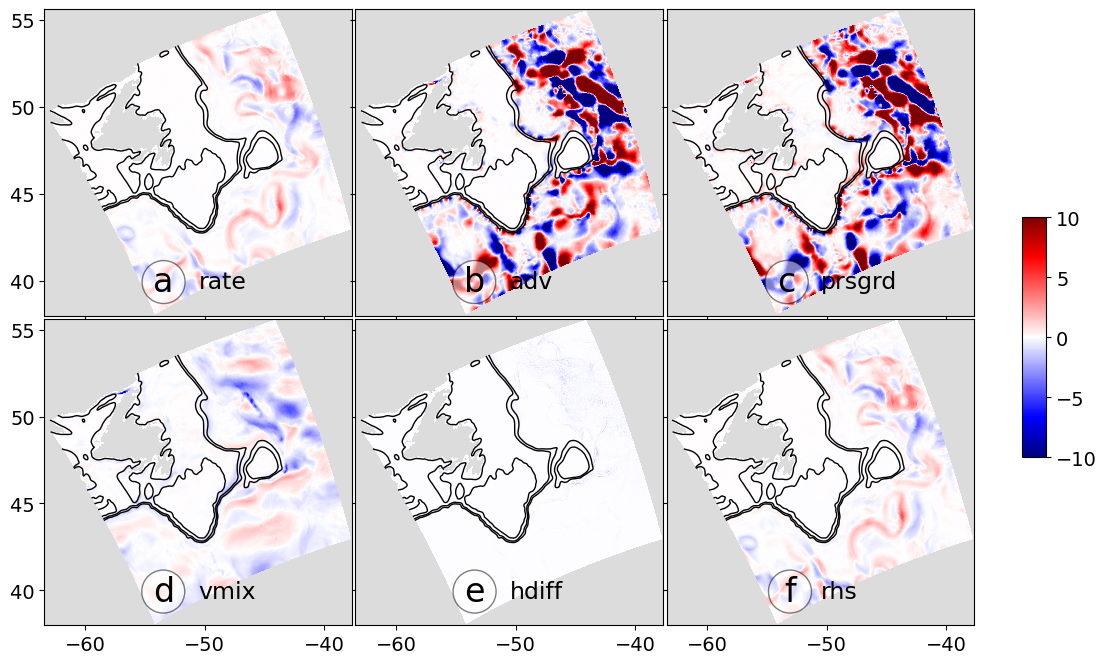

In [24]:
# execfile('subplot_EKE_balance.py')


'''

do plots for:

- plot_EKE_balance_from_online_diags.py

requires variables:

mke_rate = mke_adv + mke_prsgrd + eke_mke + mpe_mke + mke_vmix + mke_hdiff

eke_rate = eke_adv1 + eke_adv2 + eke_prsgrd + mke_eke + epe_eke [=hrs+vrs] + eke_vmix + eke_hdiff


'''
############################################################

coeflev = 10
#psi = tools.psi2rho(var('psi',simul).data/1e6)
#psi = psi - psi[800,200]

if 'baha' in mysimul or 'bimin' in mysimul:
    zoom = [-79.6, -78.01, 25.41, 27.79]
    all = [-85, -75, 24, 30]

pdf = False

############################################################

fontsize1 = 14
fontsize2 = format(17)
fontsize3 = format(24)
font = {'size'   : fontsize1}
py.rc('font', **font)

xmajorLocator   = MultipleLocator(5.)

#######################

def plot_common(myvar,title,panel):
    joe = py.pcolormesh(simul.x.T,simul.y.T,ma.masked_invalid(myvar.T),vmin=levels.min(),vmax=levels.max(),cmap=my_cmap,rasterized=True);
    #levels_contour = np.arange(0,11,1.)
    #joe_c = py.contour(simul.x.T,simul.y.T,np.abs(ma.masked_invalid(myvar.T)),levels_contour,colors = ('yellow',),linewidths = (.5,));
    #py.clabel(joe_c, fmt = '%2.1f', colors = 'yellow', fontsize=6)
    py.contour( simul.x.T,simul.y.T, simul.topo.T,[1,100,500,1000],colors = ('k',),linewidths = (1.,))
    #py.axis('scaled');  py.axis(zoom)
    t1 = py.text(0.5, 0.11,title, fontsize=fontsize2,  horizontalalignment='left', verticalalignment='center', transform = ax1.transAxes)
    color = 'w'; box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc=color, ec='k', lw=1, alpha=0.5)
    if panel!=' ': ax1.text(0.42,0.11,panel, fontsize=fontsize3,  horizontalalignment='right', verticalalignment='center', bbox=props, transform=ax1.transAxes)
    #CSpsi = py.contour(simul.x.T,simul.y.T,psi.T,np.arange(-209,300,5),linewidths = (0.5,),colors = ('g',))
    #CSpsi = py.contour(simul.x.T,simul.y.T,psi.T*simul.mask.T,[1],linewidths = (0.5,),colors = ('g',))
    return joe

############################################################


###
ke_vol = ke_term('ke_vol')
ke_cor = ke_term('ke_cor')
###

ke_rhs = ke_adv + ke_prsgrd + ke_vmix + ke_hdiff + ke_vol + ke_cor

#ek_tot = (ek_hadv + ek_vadv - ek_hdiff) +  ek_prsgrd + (ek_vmix+ ek_vmix2) + (ek_hdiff + ek_hmix)  + ek_vmix2  +  ek_cor ek_vol

#######


############################################################
# ALL TERMS
############################################################
fig = py.figure(figsize=(12,8.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev
unit=r'${\rm m}^3{\rm s}^{-3}$'; unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
ax1 = fig.add_subplot(231,facecolor='Gainsboro')
joe=plot_common(ke_rate,r'rate','a')
ax1.xaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(232,facecolor='Gainsboro')
plot_common(ke_adv,r'adv','b')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(233,facecolor='Gainsboro')
plot_common(ke_prsgrd,r'prsgrd','c')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(236,facecolor='Gainsboro')
joe=plot_common(ke_rhs,r'rhs','f')
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(235,facecolor='Gainsboro')
joe=plot_common(ke_hdiff,r'hdiff','e')
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(234,facecolor='Gainsboro')
joe=plot_common(ke_vmix,r'vmix','d')
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
py.savefig(fifig +    '_totterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
if pdf: py.savefig(fifig +    '_totterms_'   +'.pdf', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
#py.close('all')
############################################################

/tmp/ipykernel_756179/2730038630.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_sumtotterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
/tmp/ipykernel_756179/2730038630.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figure" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_sumtotterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
/tmp/ipykernel_756179/2730038630.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_sumtotterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');


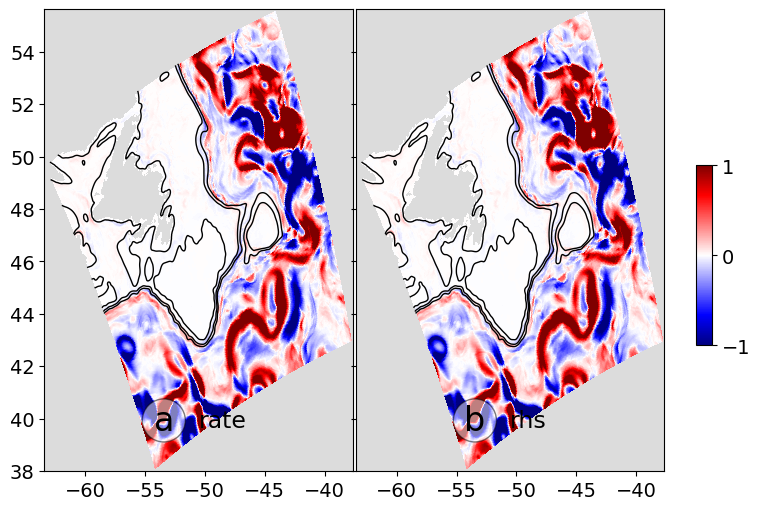

In [25]:
############################################################
# SUM OF ALL TERMS
############################################################
fig = py.figure(figsize=(8,6.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev/10.
unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
############################################################
ax1 = fig.add_subplot(121,facecolor='Gainsboro')
joe=plot_common(ke_rate,r'rate','a')
ax1.xaxis.set_major_locator(xmajorLocator)
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T,np.arange(-209,300,5),linewidths = (0.5,),colors = ('g',))
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T*simul.mask.T,[1],linewidths = (0.5,),colors = ('g',))
############################################################
ax1 = fig.add_subplot(122,facecolor='Gainsboro')
joe=plot_common(ke_rhs,r'rhs','b')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
py.savefig(fifig +    '_sumtotterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
if pdf: py.savefig(fifig +    '_sumtotterms_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');

#####################

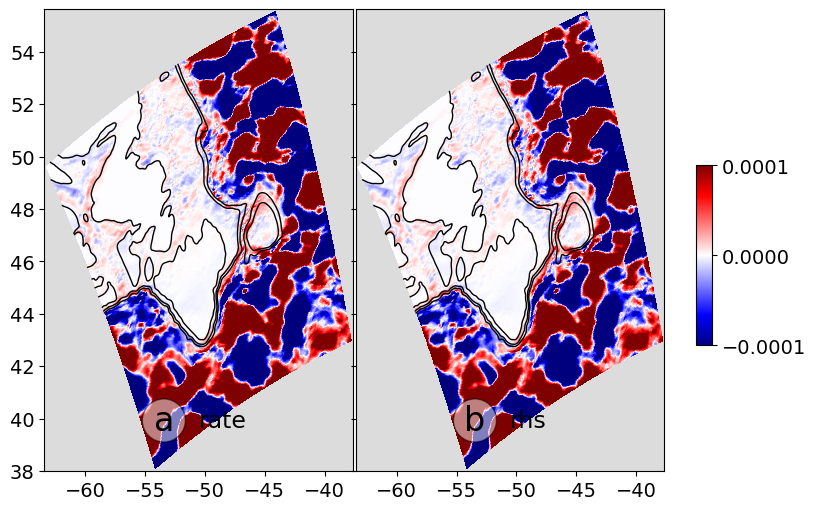

In [26]:
# momentum terms:

#rhs = adv + prsgrd + vmix + hdiff + vol + cor

M_rate = get_M_term('rate')
M_rhs = get_M_term('adv') + get_M_term('prsgrd') + get_M_term('vmix') + get_M_term('fast') +  get_M_term('cor')


############################################################
# SUM OF MOMENTUM TERMS
############################################################
fig = py.figure(figsize=(8,6.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev/100000.
unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
############################################################
ax1 = fig.add_subplot(121,facecolor='Gainsboro')
joe=plot_common(M_rate,r'rate','a')
ax1.xaxis.set_major_locator(xmajorLocator)
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T,np.arange(-209,300,5),linewidths = (0.5,),colors = ('g',))
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T*simul.mask.T,[1],linewidths = (0.5,),colors = ('g',))
############################################################
ax1 = fig.add_subplot(122,facecolor='Gainsboro')
joe=plot_common(M_rhs,r'rhs','b')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
#py.savefig(fifig +    '_sumtotterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
#if pdf: py.savefig(fifig +    '_sumtotterms_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');

#####################

/tmp/ipykernel_756179/1440163710.py:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_meanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
/tmp/ipykernel_756179/1440163710.py:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figure" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_meanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
/tmp/ipykernel_756179/1440163710.py:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_meanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');


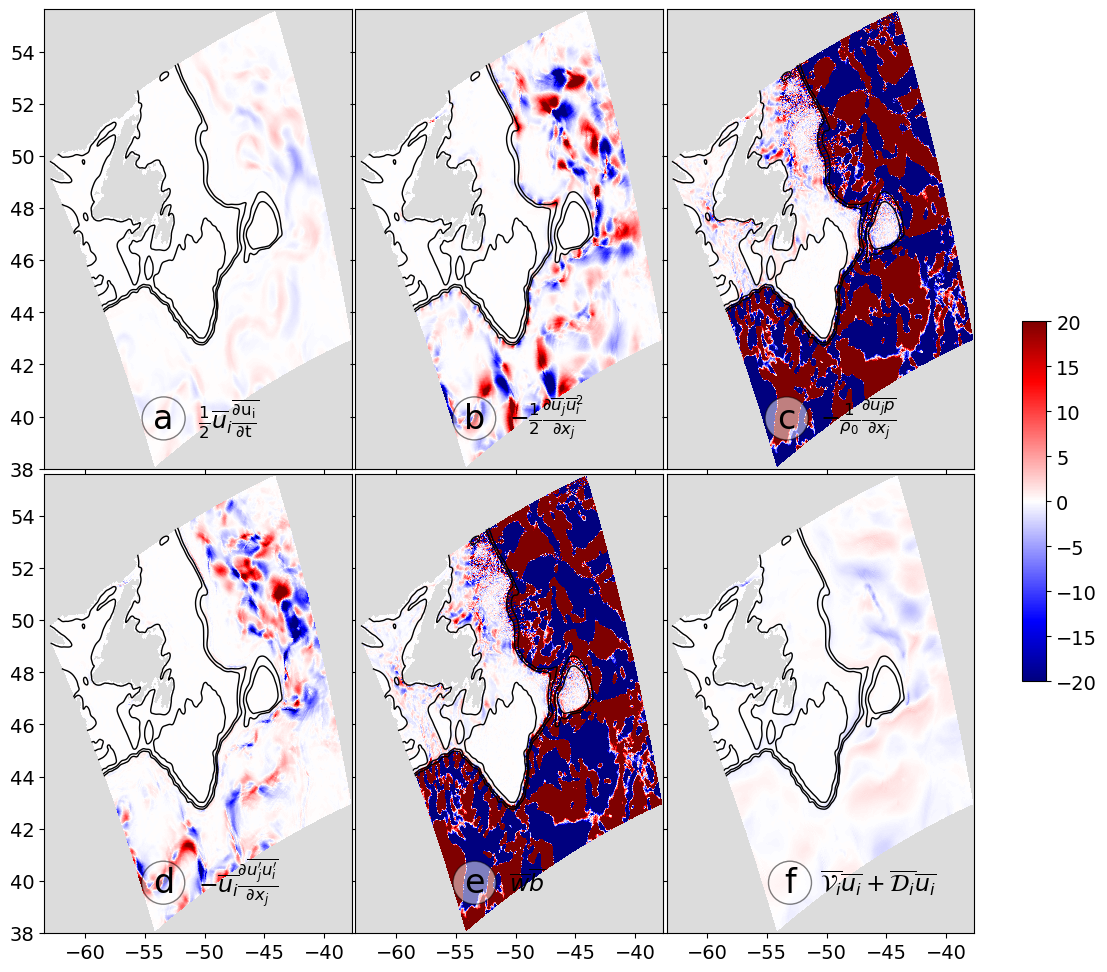

In [27]:
############################################################
# ALL MEAN TERMS
############################################################
fig = py.figure(figsize=(12,12.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev*2.
unit=r'${\rm m}^3{\rm s}^{-3}$'; unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
ax1 = fig.add_subplot(231,facecolor='Gainsboro')
joe=plot_common(mke_rate,r'$\frac{1}{2}\overline{u}_i \overline{\frac{\partial{\rm u_i}}{\partial{\rm t}}}$','a')
ax1.xaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(232,facecolor='Gainsboro')
plot_common(mke_adv,r'$-\frac{1}{2}\frac{\partial \overline{u}_j  \overline{u}_i^{2}}{\partial x_j}$','b')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(233,facecolor='Gainsboro')
plot_common(mke_prsgrd,r'$- \frac{1}{\rho_0}\frac{\partial \overline{u_j} \overline{p}}{\partial x_j}$','c')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(236,facecolor='Gainsboro')
joe=plot_common(mke_vmix + mke_hdiff,r'$\overline{\mathcal{V}_i}    \overline{u_i} +\overline{\mathcal{D}_i}    \overline{u_i}$','f')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
#ax1 = fig.add_subplot(248,facecolor='Gainsboro')
#joe=plot_common(Hdiff_mean,r'$\overline{\mathcal{D}_i}    \overline{u_i}$','g')
#ax1.xaxis.set_major_locator(xmajorLocator)
#ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(235,facecolor='Gainsboro')
joe=plot_common(mpe_mke,r'$\overline{w} \overline{b }$','e')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(234,facecolor='Gainsboro')
joe=plot_common(eke_mke,r'$- \overline{u_i} \frac{\partial \overline{u_j^{\prime} u_i^{\prime}}}{\partial x_j}$','d')
ax1.xaxis.set_major_locator(xmajorLocator)
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
py.savefig(fifig +    '_meanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
if pdf: py.savefig(fifig +    '_meanterms_'   +'.pdf', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
#py.close('all')

/tmp/ipykernel_756179/3867921691.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_summeanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
/tmp/ipykernel_756179/3867921691.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figure" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_summeanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
/tmp/ipykernel_756179/3867921691.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_summeanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');


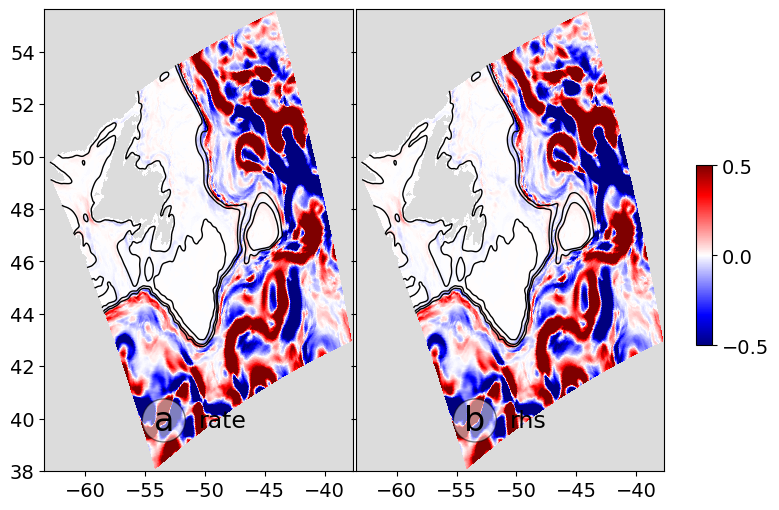

In [28]:
############################################################
# MEAN CHART
############################################################
#allmeanterms = adv_mean + eddyforcing + Prsgrd_mean + Vmix_mean + Hdiff_mean
#rhs = adv + prsgrd + vmix + hdiff + vol + cor

mke_cor = mke_term('cor')*coef

mke_rhs = mke_adv + eke_mke + mke_prsgrd  + mpe_mke + mke_vmix + mke_hdiff +  mke_cor

#

############################################################
# SUM OF MEAN TERMS
############################################################
fig = py.figure(figsize=(8,6.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev/20.
unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
############################################################
ax1 = fig.add_subplot(121,facecolor='Gainsboro')
joe=plot_common(mke_rate,r'rate','a')
ax1.xaxis.set_major_locator(xmajorLocator)
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T,np.arange(-209,300,5),linewidths = (0.5,),colors = ('g',))
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T*simul.mask.T,[1],linewidths = (0.5,),colors = ('g',))
############################################################
ax1 = fig.add_subplot(122,facecolor='Gainsboro')
joe=plot_common(mke_rhs,r'rhs','b')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
py.savefig(fifig +    '_summeanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
if pdf: py.savefig(fifig +    '_summeanterms_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');

#py.close('all')
#####################

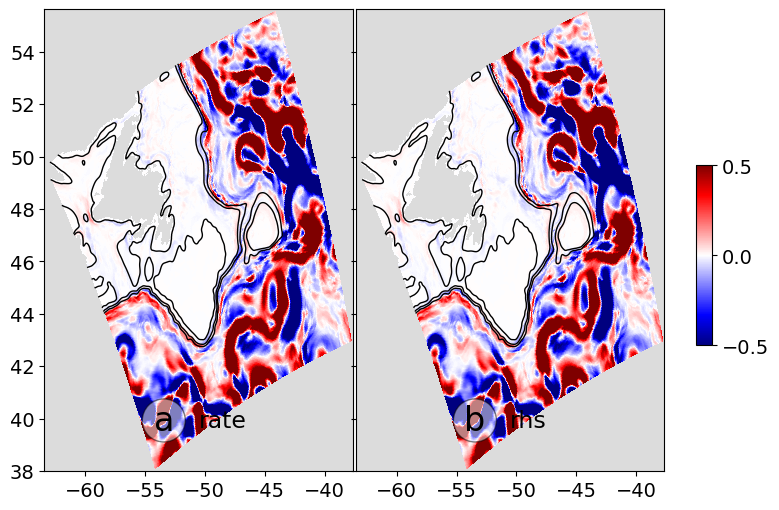

In [29]:
# Check

mke_rhs2 = ( mke_term('adv') + mke_term('prsgrd')  + mke_term('vmix') + mke_term('fast') + 0.*mke_term('hmix') +  mke_term('cor') )  * coef


############################################################
# SUM OF MEAN TERMS
############################################################
fig = py.figure(figsize=(8,6.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev/20.
unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
############################################################
ax1 = fig.add_subplot(121,facecolor='Gainsboro')
joe=plot_common(mke_rhs2,r'rate','a')
ax1.xaxis.set_major_locator(xmajorLocator)
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T,np.arange(-209,300,5),linewidths = (0.5,),colors = ('g',))
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T*simul.mask.T,[1],linewidths = (0.5,),colors = ('g',))
############################################################
ax1 = fig.add_subplot(122,facecolor='Gainsboro')
joe=plot_common(mke_rhs,r'rhs','b')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
#py.savefig(fifig +    '_summeanterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
if pdf: py.savefig(fifig +    '_summeanterms_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');


/tmp/ipykernel_756179/183670209.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_eddyterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
/tmp/ipykernel_756179/183670209.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figure" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_eddyterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
/tmp/ipykernel_756179/183670209.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_eddyterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');


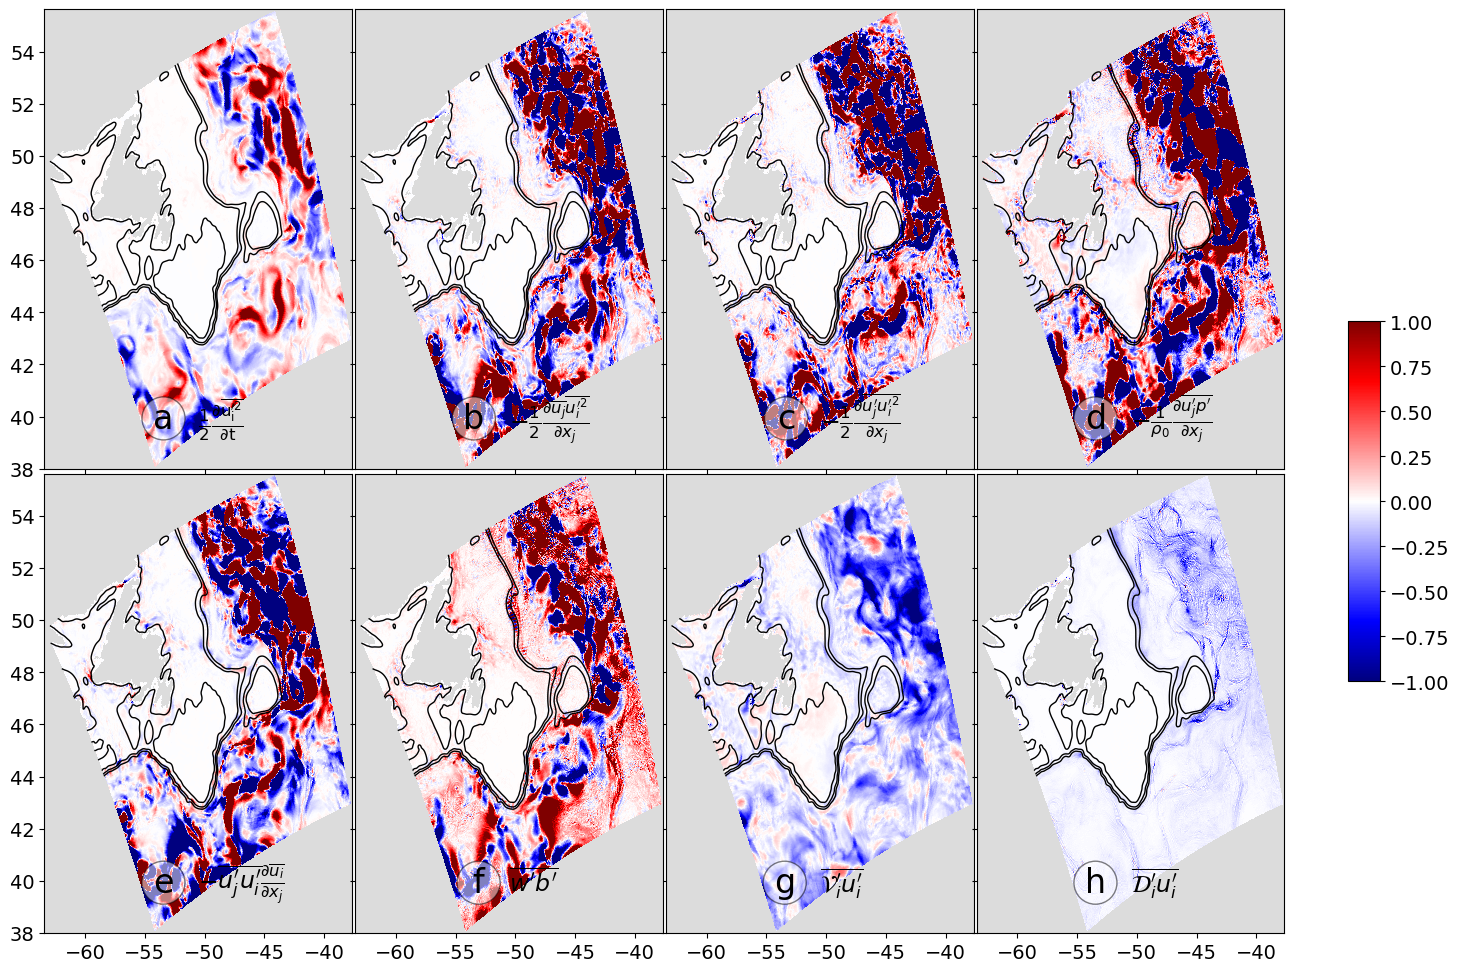

In [30]:
############################################################
# ALL EDDY TERMS
############################################################
fig = py.figure(figsize=(16,12.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev*0.1
unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
ax1 = fig.add_subplot(241,facecolor='Gainsboro')
joe=plot_common(eke_rate,r'$\frac{1}{2}\frac{\partial{\rm \overline{u_i^{\prime 2}}}}{\partial{\rm t}}$','a')
ax1.xaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(242,facecolor='Gainsboro')
plot_common(eke_adv1,r'$-\frac{1}{2} \frac{\partial \overline{u_j} \overline{u_i^{\prime 2}}}{\partial x_j}$','b')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(243,facecolor='Gainsboro')
plot_common(eke_adv2,r'$- \frac{1}{2}\frac{\partial \overline{u_j^{\prime} u_i^{\prime 2}}}{\partial x_j}$','c')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(244,facecolor='Gainsboro')
plot_common(eke_prsgrd,r'$- \frac{1}{\rho_0}\frac{\partial \overline{u_j^{\prime} p^{\prime}}}{\partial x_j}$','d')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(247,facecolor='Gainsboro')
joe=plot_common(eke_vmix,r'$\overline{\mathcal{V}^{\prime}_i    u^{\prime}_i}$','g')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(248,facecolor='Gainsboro')
joe=plot_common(eke_hdiff,r'$\overline{\mathcal{D}^{\prime}_i    u^{\prime}_i} $','h')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
ax1 = fig.add_subplot(245,facecolor='Gainsboro')
joe=plot_common(mke_eke,r'$- \overline{u_j^{\prime} u_i^{\prime}} \frac{\partial \overline{u_i}}{\partial x_j}$','e')
ax1.xaxis.set_major_locator(xmajorLocator)
############################################################
ax1 = fig.add_subplot(246,facecolor='Gainsboro')
joe=plot_common(epe_eke,r'$\overline{w^{\prime} b^{\prime} }$','f')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
py.savefig(fifig +    '_eddyterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');
if pdf: py.savefig(fifig +    '_eddyterms_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=300,bbox_inches='tight');

#py.close('all')
############################################################

In [31]:
# for EKE equation:
# eke_rate = eke_adv1 + eke_adv2 + eke_prsgrd + mke_eke + epe_eke + eke_vmix + eke_hdiff
############################################################
# EDDY CHART
############################################################


#ke_rhs = ke_adv + ke_prsgrd + ke_vmix + ke_hdiff + ke_vol + ke_cor
#mke_rhs = mke_adv + eke_mke + mke_prsgrd  + mpe_mke + mke_vmix + mke_hdiff +  mke_term('cor')*coef

#eke_adv1 + eke_adv2 + mke_eke = ke_adv - (mke_adv+eke_mke)
#eke_prsgrd + epe_eke = ke_prsgrd - (mke_prsgrd + mpe_mke) 
#eke_vmix = ke_vmix - mke_vmix
#eke_hdiff = ke_hdiff - mke_hdiff

eke_rhs = eke_adv1 + eke_adv2 + mke_eke + eke_prsgrd  + epe_eke + eke_vmix + eke_hdiff + (ke_vol + ke_cor - mke_cor)

'''
chartnames = ['all','eddy1']

for id,myzoom in enumerate([all,zoom]):
    chartname = chartnames[id]
    mymask = copy(simul.mask)*norm
    mymask[simul.y>myzoom[3]]=np.nan
    mymask[simul.y<myzoom[2]]=np.nan
    mymask[simul.x>myzoom[1]]=np.nan
    mymask[simul.x<myzoom[0]]=np.nan
    term = np.zeros(10)
    term[1] = simul.rho0*np.nansum(eke_rate*mymask)
    term[2] = simul.rho0*np.nansum(eke_adv1*mymask)
    term[3] = simul.rho0*np.nansum(eke_adv2*mymask)
    term[4] = simul.rho0*np.nansum(eke_prsgrd*mymask)
    term[5] = simul.rho0*np.nansum(eke_vmix*mymask)
    term[6] = simul.rho0*np.nansum(eke_hdiff*mymask)
    term[7] = simul.rho0*np.nansum(mke_eke*mymask)
    term[8] = simul.rho0*np.nansum(epe_eke*mymask)
    term[9] = simul.rho0*np.nansum(eke_rhs*mymask)
    termeddy = term
    execfile('plot_chart_eddy.py')'''

"\nchartnames = ['all','eddy1']\n\nfor id,myzoom in enumerate([all,zoom]):\n    chartname = chartnames[id]\n    mymask = copy(simul.mask)*norm\n    mymask[simul.y>myzoom[3]]=np.nan\n    mymask[simul.y<myzoom[2]]=np.nan\n    mymask[simul.x>myzoom[1]]=np.nan\n    mymask[simul.x<myzoom[0]]=np.nan\n    term = np.zeros(10)\n    term[1] = simul.rho0*np.nansum(eke_rate*mymask)\n    term[2] = simul.rho0*np.nansum(eke_adv1*mymask)\n    term[3] = simul.rho0*np.nansum(eke_adv2*mymask)\n    term[4] = simul.rho0*np.nansum(eke_prsgrd*mymask)\n    term[5] = simul.rho0*np.nansum(eke_vmix*mymask)\n    term[6] = simul.rho0*np.nansum(eke_hdiff*mymask)\n    term[7] = simul.rho0*np.nansum(mke_eke*mymask)\n    term[8] = simul.rho0*np.nansum(epe_eke*mymask)\n    term[9] = simul.rho0*np.nansum(eke_rhs*mymask)\n    termeddy = term\n    execfile('plot_chart_eddy.py')"

/tmp/ipykernel_756179/2838985195.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_hrsvrs_' +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
/tmp/ipykernel_756179/2838985195.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figure" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_hrsvrs_' +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
/tmp/ipykernel_756179/2838985195.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_hrsvrs_' +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');


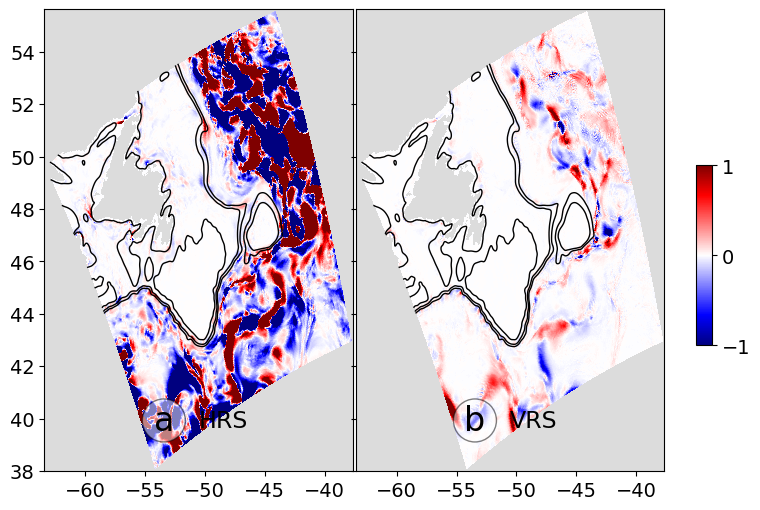

In [32]:
############################################################
# HRS / VRS
############################################################
fig = py.figure(figsize=(8,6.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev*1e-1
unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
############################################################
ax1 = fig.add_subplot(121,facecolor='Gainsboro')
joe=plot_common(hrs,'HRS','a')
ax1.xaxis.set_major_locator(xmajorLocator)
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T,np.arange(-209,300,5),linewidths = (0.5,),colors = ('g',))
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T*simul.mask.T,[1],linewidths = (0.5,),colors = ('g',))
############################################################
ax1 = fig.add_subplot(122,facecolor='Gainsboro')
joe=plot_common(vrs,'VRS','b')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
py.savefig(fifig +    '_hrsvrs_' +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
if pdf: py.savefig(fifig +    '_hrsvrs_' + 'pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');

#py.close('all')
#####################

/tmp/ipykernel_756179/887364394.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_sumeddyterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
/tmp/ipykernel_756179/887364394.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figure" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_sumeddyterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
/tmp/ipykernel_756179/887364394.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_sumeddyterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');


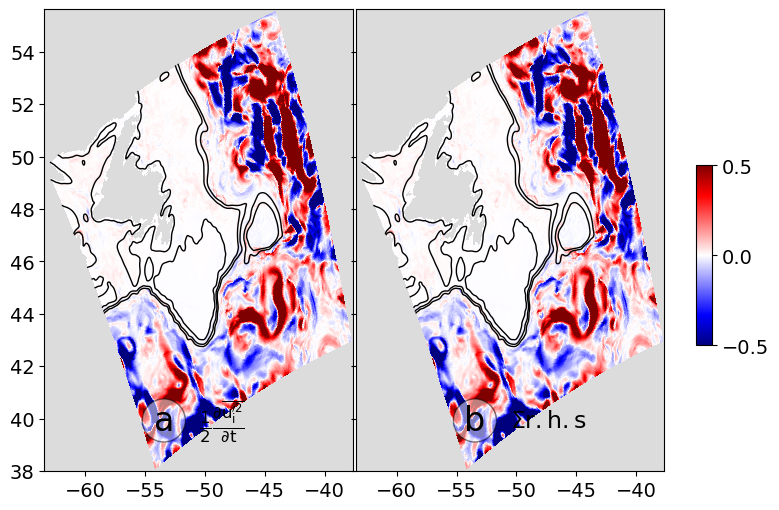

In [33]:
############################################################
# SUM OF EDDY TERMS
############################################################
fig = py.figure(figsize=(8,6.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev/20.
unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
############################################################
ax1 = fig.add_subplot(121,facecolor='Gainsboro')
joe=plot_common(eke_rate,r'$\frac{1}{2}\frac{\partial {\rm \overline{u_i^{\prime 2}}}}{\partial{\rm t}}$','a')
ax1.xaxis.set_major_locator(xmajorLocator)
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T,np.arange(-209,300,5),linewidths = (0.5,),colors = ('g',))
#CSpsi = py.contour(simul.x.T,simul.y.T,psi.T*simul.mask.T,[1],linewidths = (0.5,),colors = ('g',))
############################################################
ax1 = fig.add_subplot(122,facecolor='Gainsboro')
joe=plot_common(eke_rhs,r'$\Sigma {\rm r.h.s}$','b')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
py.savefig(fifig +    '_sumeddyterms_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
if pdf: py.savefig(fifig +    '_sumeddyterms_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');

#py.close('all')
#####################

/tmp/ipykernel_756179/869120202.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_article_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');
/tmp/ipykernel_756179/869120202.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figure" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_article_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');
/tmp/ipykernel_756179/869120202.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "magnification" which is no longer supported as of 3.3 and will become an error in 3.6
  py.savefig(fifig +    '_article_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');


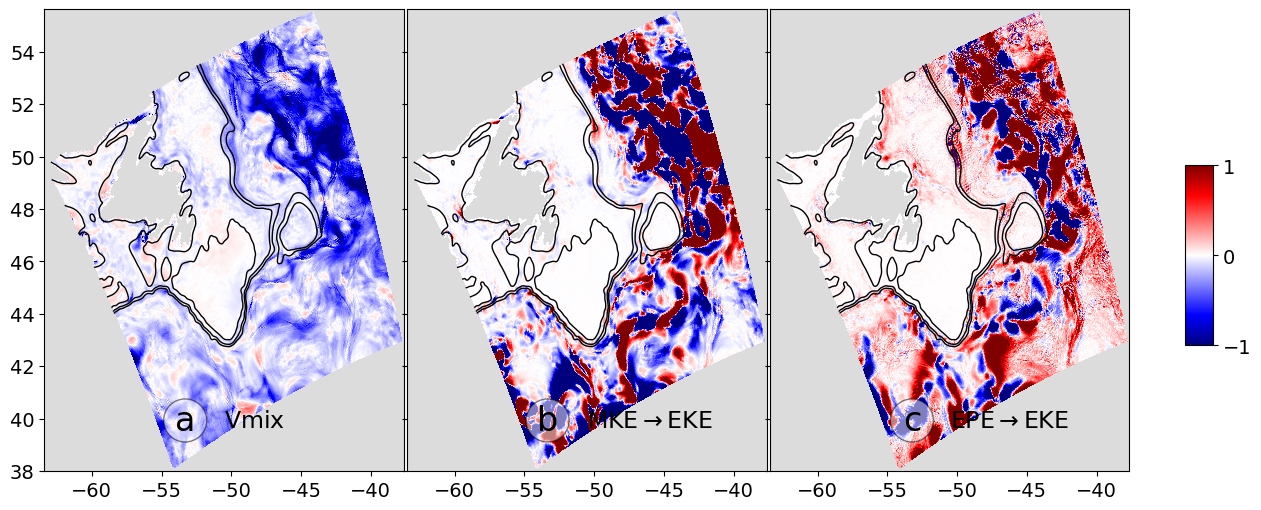

In [34]:
diss = eke_vmix + eke_hdiff
#diss[diss>0]=0

############################################################
zoom2 = [-79.39, -79.11, 25.61, 26.2]

############################################################
# ARTICLE
############################################################
fig = py.figure(figsize=(14,6.))
############################################################
levels=np.arange(-1,1.01,0.01)*coeflev*0.1
unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')
############################################################
ax1 = fig.add_subplot(131,facecolor='Gainsboro')
joe=plot_common(diss,r'${\rm Vmix} $','a')
#t2 = ax1.text(0.5, 0.05,r'${\rm Terms}$', fontsize=fontsize2,  horizontalalignment='left', verticalalignment='center', transform = ax1.transAxes)
ax1.xaxis.set_major_locator(xmajorLocator)
############################################################
ax1 = fig.add_subplot(132,facecolor='Gainsboro')
joe=plot_common(hrs+vrs,r'${\rm MKE \rightarrow EKE }$','b')
ax1.xaxis.set_major_locator(xmajorLocator)
#ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )
#############################################################
ax1 = fig.add_subplot(133,facecolor='Gainsboro')
joe=plot_common(epe_eke,r'${\rm EPE \rightarrow EKE}$','c')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )
############################################################
py.subplots_adjust(wspace=0.01,hspace=0.01)
py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
#py.savefig(fifig +    '_article_'  +'.png', size=None, figure=None, magnification='auto', dpi=400,bbox_inches='tight');
py.savefig(fifig +    '_article_'  +'.pdf', size=None, figure=None, magnification='auto', dpi=600,bbox_inches='tight');
#py.close('all')
############################################################


##################################################

# Integrate terms between vertical levels

In [ ]:


int_ver_0 = -500
int_ver_1 = -1000
int_ver_2 = -1500
int_ver_3 = -2500

[z_r,z_w] = tools.get_depths(simul)


#############
# 6. mke_eke = [hrs+vrs]
#############



umean =  tools.u2rho(ionetcdf.get(meanfile_avg,'u',simul,time=season))[x1:x2,y1:y2,:]
vmean =  tools.v2rho(ionetcdf.get(meanfile_avg,'v',simul,time=season))[x1:x2,y1:y2,:]
uvmean =  ionetcdf.get(meanfile_eddy,'uv',simul,time=season)[x1:x2,y1:y2,:]
dxv = tools.u2rho(tools.diffxi(vmean,simul.pm,z_r,z_w))
hrsz = -(uvmean - umean*vmean)*dxv
del dxv
dyu = tools.v2rho(tools.diffeta(umean,simul.pn,z_r,z_w))
hrsz += -(uvmean - umean*vmean)*dyu
del uvmean, dyu
uumean =  ionetcdf.get(meanfile_eddy,'uu',simul,time=season)[x1:x2,y1:y2,:]
dxu = tools.u2rho(tools.diffxi(umean,simul.pm,z_r,z_w))
hrsz += -(uumean - umean**2)*dxu
del uumean, dxu
vvmean =  ionetcdf.get(meanfile_eddy,'vv',simul,time=season)[x1:x2,y1:y2,:]
dyv = tools.v2rho(tools.diffeta(vmean,simul.pn,z_r,z_w))
hrsz += -(vvmean - vmean**2)*dyv
del vvmean, dyv

hrsz0 = tools.vert_int(hrsz,z_w,int_ver_0,int_ver_1)*coef
hrsz1 = tools.vert_int(hrsz,z_w,int_ver_1,int_ver_2)*coef
hrsz2 = tools.vert_int(hrsz,z_w,int_ver_2,int_ver_3)*coef
hrsz3 = tools.vert_int(hrsz,z_w,int_ver_0,int_ver_3)*coef

####

umean0 = tools.vert_int(umean,z_w,int_ver_0,int_ver_1)/(int_ver_0-int_ver_1)
umean1 = tools.vert_int(umean,z_w,int_ver_1,int_ver_2)/(int_ver_1-int_ver_2)
umean2 = tools.vert_int(umean,z_w,int_ver_2,int_ver_3)/(int_ver_2-int_ver_3)
umean3 = tools.vert_int(umean,z_w,int_ver_0,int_ver_3)/(int_ver_0-int_ver_3)

vmean0 = tools.vert_int(vmean,z_w,int_ver_0,int_ver_1)/(int_ver_0-int_ver_1)
vmean1 = tools.vert_int(vmean,z_w,int_ver_1,int_ver_2)/(int_ver_1-int_ver_2)
vmean2 = tools.vert_int(vmean,z_w,int_ver_2,int_ver_3)/(int_ver_2-int_ver_3)
vmean3 = tools.vert_int(vmean,z_w,int_ver_0,int_ver_3)/(int_ver_0-int_ver_3)

[umean0,vmean0] = tools.rotuv(simul,umean0,vmean0,psi=False)
[umean1,vmean1] = tools.rotuv(simul,umean1,vmean1,psi=False)
[umean2,vmean2] = tools.rotuv(simul,umean2,vmean2,psi=False)
[umean3,vmean3] = tools.rotuv(simul,umean3,vmean3,psi=False)

####

print('compute VRS')
try:
    wmean = ionetcdf.get(meanfile_avg,'w',simul,time=season)[x1:x2,y1:y2,:]
    print('load wmean from mean file')
except:
    print('computing wmean')
    wmean = var('w',simul).data


umean =  tools.u2rho(ionetcdf.get(meanfile_avg,'u',simul,time=season))[x1:x2,y1:y2,:]
uwmean = ionetcdf.get(meanfile_eddy,'uw',simul,time=season)[x1:x2,y1:y2,:]\
       - umean * wmean

dzu = (umean[:,:,1:]-umean[:,:,:-1])/(z_r[:,:,1:] - z_r[:,:,:-1])
del umean
vrsz = -0.5*(uwmean[:,:,1:]+uwmean[:,:,:-1])*dzu
del uwmean,dzu

vmean =  tools.v2rho(ionetcdf.get(meanfile_avg,'v',simul,time=season))[x1:x2,y1:y2,:]
vwmean = ionetcdf.get(meanfile_eddy,'vw',simul,time=season)[x1:x2,y1:y2,:]\
       - vmean * wmean
del wmean

dzv = (vmean[:,:,1:]-vmean[:,:,:-1])/(z_r[:,:,1:] - z_r[:,:,:-1])
del vmean
vrsz += -0.5*(vwmean[:,:,1:]+vwmean[:,:,:-1])*dzv
del vwmean,dzv

############################################################

vrsz0 = tools.vert_int(vrsz[:,:,:],z_r,int_ver_0,int_ver_1)*coef
vrsz1 = tools.vert_int(vrsz[:,:,:],z_r,int_ver_1,int_ver_2)*coef
vrsz2 = tools.vert_int(vrsz[:,:,:],z_r,int_ver_2,int_ver_3)*coef
vrsz3 = tools.vert_int(vrsz[:,:,:],z_r,int_ver_0,int_ver_3)*coef

############################################################






#############
# 8. eke_prsgrd,epe_eke
#############

print('compute epe_eke')
try:
    wmean = ionetcdf.get(meanfile_avg,'w',simul,time=season)[x1:x2,y1:y2,:]
    print('load wmean from mean file')
except:
    print('computing wmean')
    wmean = var('w',simul).data

try:    
    bmean =  -simul.g/simul.rho0*(ionetcdf.get(meanfile_avg,'rho',simul,time=season)[x1:x2,y1:y2,:])
    print('load bmean from mean file')
except:
    print('computing bmean')
    bmean = var('buoy',simul).data

wbmean =  ionetcdf.get(meanfile_eddy,'wb',simul,time=season)[x1:x2,y1:y2,:]
vbf = wbmean - wmean*bmean; del wmean, bmean, wbmean


epe_ekez0 = tools.vert_int(vbf,z_w,int_ver_0,int_ver_1)*coef
epe_ekez1 = tools.vert_int(vbf,z_w,int_ver_1,int_ver_2)*coef
epe_ekez2 = tools.vert_int(vbf,z_w,int_ver_2,int_ver_3)*coef
epe_ekez3 = tools.vert_int(vbf,z_w,int_ver_0,int_ver_3)*coef




#########



############################################################


In [ ]:

zoom = [-60, -48, 4., 12.]

levels=np.arange(-1,1.01,0.01)*0.1


i_sec = 110
dx=10

j_sec = 240
dy=10

############################################################


fontsize1 = 14
fontsize2 = format(17)
fontsize3 = format(24)
font = {'size'   : fontsize1}
py.rc('font', **font)

xmajorLocator   = MultipleLocator(5.)

######

def plot_common_uv(myvar,u,v,title,panel):
    joe = py.pcolormesh(simul.x.T,simul.y.T,ma.masked_invalid(myvar.T),\
                        vmin=levels.min(),vmax=levels.max(),cmap=my_cmap,rasterized=True);
    #joe_c = py.contour(simul.x.T,simul.y.T,np.abs(ma.masked_invalid(myvar.T)),levels_contour,colors = ('yellow',),linewidths = (.5,));
    #py.clabel(joe_c, fmt = '%2.1f', colors = 'yellow', fontsize=6)
    
    #################
    # add vectors
    #################

    nnu = nnv = 20; normu = 0.1
    CS1u = plt.quiver(simul.x[::nnu,::nnv],simul.y[::nnu,::nnv],u[::nnu,::nnv], v[::nnu,::nnv],\
                                        pivot='mid',color='k',\
                                        scale=1.,minlength=0,minshaft=2,alpha=0.8);
    t1=plt.quiverkey(CS1u,0.2,0.2,normu,r'$u,v\,=\,$' + format(normu) + '$\,m.s^{-1}$',\
                     coordinates='axes',color='r',fontproperties={'size': '12' })

    
    py.contour( simul.x.T,simul.y.T, simul.topo.T,[500,1000,2500],colors = ('k',),linewidths = (1.,))
    py.axis('scaled'); py.axis(zoom)
    
    py.plot(simul.x[i_sec-dx,:],simul.y[i_sec-dx,:], '--')
    py.plot(simul.x[i_sec+dx,:],simul.y[i_sec+dx,:], '--')
    
    #py.plot(simul.x[:,j_sec-dy],simul.y[:,j_sec-dy], '--')
    #py.plot(simul.x[:,j_sec+dy],simul.y[:,j_sec+dy], '--')
    
    t1 = py.text(0.1, 0.11,title, fontsize=fontsize2,  horizontalalignment='left', verticalalignment='center', transform = ax1.transAxes)
    color = 'w'; box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc=color, ec='k', lw=1, alpha=0.5)
    if panel!=' ': ax1.text(0.8,0.9,panel, fontsize=fontsize3,  horizontalalignment='right', verticalalignment='center', bbox=props, transform=ax1.transAxes)
    #CSpsi = py.contour(simul.x.T,simul.y.T,psi.T,np.arange(-209,300,5),linewidths = (0.5,),colors = ('g',))
    #CSpsi = py.contour(simul.x.T,simul.y.T,psi.T*simul.mask.T,[1],linewidths = (0.5,),colors = ('g',))
    
    return joe

############################################################
# ARTICLE
############################################################
fig = py.figure(figsize=(16,20.))
############################################################

unit=r'${\rm m}^3{\rm s}^{-3}$';
unit=r'${\rm W\,m\,kg}^{-1}$';
scale=r'$\times 10^{-4}$'
my_cmap= plot.ncview_colormap('blue_red')

############################################################
ax1 = fig.add_subplot(421,facecolor='Gainsboro')
joe=plot_common_uv(hrsz0+vrsz0,umean0,vmean0, format(int_ver_0) +' m' + ' to ' + format(int_ver_1) + ' m','a')
plt.title(r'${\rm MKE \rightarrow EKE }$', fontsize=20)
ax1.xaxis.set_major_formatter( NullFormatter() )
#############################################################
ax1 = fig.add_subplot(422,facecolor='Gainsboro')
joe=plot_common_uv(epe_ekez0,umean0,vmean0,format(int_ver_0) +' m' + ' to ' + format(int_ver_1) + ' m','b')
plt.title(r'${\rm EPE \rightarrow EKE}$', fontsize=20)
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )

############################################################
ax1 = fig.add_subplot(423,facecolor='Gainsboro')
joe=plot_common_uv(hrsz1+vrsz1,umean1,vmean1,format(int_ver_1) +' m' + ' to ' + format(int_ver_2) + ' m','c')
ax1.xaxis.set_major_formatter( NullFormatter() )
#############################################################
ax1 = fig.add_subplot(424,facecolor='Gainsboro')
joe=plot_common_uv(epe_ekez1,umean1,vmean1,format(int_ver_1) +' m' + ' to ' + format(int_ver_2) + ' m','d')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )

############################################################
ax1 = fig.add_subplot(425,facecolor='Gainsboro')
joe=plot_common_uv(hrsz2+vrsz2,umean2,vmean2,format(int_ver_2) +' m' + ' to ' + format(int_ver_3) + ' m','e')
ax1.xaxis.set_major_formatter( NullFormatter() )
#############################################################
ax1 = fig.add_subplot(426,facecolor='Gainsboro')
joe=plot_common_uv(epe_ekez2,umean2,vmean2,format(int_ver_2) +' m' + ' to ' + format(int_ver_3) + ' m','f')
ax1.xaxis.set_major_formatter( NullFormatter() )
ax1.yaxis.set_major_formatter( NullFormatter() )

############################################################
ax1 = fig.add_subplot(427,facecolor='Gainsboro')
joe=plot_common_uv(hrsz3+vrsz3,umean3,vmean3,format(int_ver_0) +' m' + ' to ' + format(int_ver_3) + ' m','g')
ax1.xaxis.set_major_locator(xmajorLocator)
#############################################################
ax1 = fig.add_subplot(428,facecolor='Gainsboro')
joe=plot_common_uv(epe_ekez3,umean3,vmean3,format(int_ver_0) +' m' + ' to ' + format(int_ver_3) + ' m','h')
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.yaxis.set_major_formatter( NullFormatter() )

############################################################
py.subplots_adjust(wspace=0.1,hspace=0.1)
#py.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.94, 0.32, 0.02, 0.30])
fig.colorbar(joe, cax=cbar_ax) #,ticks=oldsim.clabels(levels))
py.savefig(fifig +    '_article_'  +'.png', size=None, figure=None, magnification='auto', dpi=200,bbox_inches='tight');
#py.close('all')
############################################################


##################################################

# plot a vertical section of HRS

In [ ]:


####

rho_sec_x = np.nanmean(var('rho1',simul).data[i_sec-dx:i_sec+dx,:,:],axis=0) + simul.rho0 - 1000.
#rho_sec_y = np.nanmean(var('rho1',simul).data[:,j_sec-dy:j_sec+dy,:],axis=1) + simul.rho0 - 1000.

####
# define lon in 3d
lat3d = copy(z_r)
for iz in range(lat3d.shape[2]):
    lat3d[:,:,iz] = simul.y

    
lat_sec_x = np.nanmean(lat3d[i_sec-dx:i_sec+dx,:,:],axis=0)
#lat_sec_y = np.nanmean(lat3d[:,j_sec-dy:j_sec+dy,:],axis=1)


In [ ]:



############################
    
levels=np.arange(-1,1.01,0.01)*0.3e-7
sigs = np.array([26.4, 27.0, 27.1, 27.2, 27.3, 27.35, 27.4, 27.45, 27.5, 27.6, 27.8, 27.88]) # for plotting isopycnals

############################

fig = plt.figure(figsize=(18.0,6.0))
fig.set_tight_layout(1.)

###################

ax1 = plt.subplot(1,3,1);
plt.pcolormesh(lat_sec_x, np.nanmean(z_r[i_sec-dx:i_sec+dx,:,:],axis=0),
                np.nanmean(hrsz[i_sec-dx:i_sec+dx,:,:],axis=0), vmin=levels.min(),vmax=levels.max(),cmap=my_cmap,rasterized=True); plt.colorbar()


CS2 = plt.contour(lat_sec_x, np.nanmean(z_r[i_sec-dx:i_sec+dx,:,:],axis=0),
                rho_sec_x,sigs,colors = ('k',), linewidths = (0.8,));
plt.clabel(CS2, fmt = '%1.4f', colors = 'k', fontsize=6)  ;

plt.ylabel(r'z [m]',fontsize=18)
plt.xlabel(r'lat',fontsize=18)
plt.xlim([6.5, 10]); plt.ylim([-3500, 0])
plt.title(r'${\rm HRS }$', fontsize=20)

###################

ax1 = plt.subplot(1,3,2);
plt.pcolormesh(lat_sec_x[:,1:], np.nanmean(z_w[i_sec-dx:i_sec+dx,:,1:-1],axis=0),
                np.nanmean(vrsz[i_sec-dx:i_sec+dx,:,:],axis=0), vmin=levels.min(),vmax=levels.max(),cmap=my_cmap,rasterized=True); plt.colorbar()


CS2 = plt.contour(lat_sec_x, np.nanmean(z_r[i_sec-dx:i_sec+dx,:,:],axis=0),
                rho_sec_x,sigs,colors = ('k',), linewidths = (0.8,));
plt.clabel(CS2, fmt = '%1.4f', colors = 'k', fontsize=6)  ;

plt.ylabel(r'z [m]',fontsize=18)
plt.xlabel(r'lat',fontsize=18)
plt.xlim([6.5, 10]); plt.ylim([-3500, 0])
plt.title(r'${\rm VRS }$', fontsize=20)

###################

ax1 = plt.subplot(1,3,3);
plt.pcolormesh(lat_sec_x, np.nanmean(z_r[i_sec-dx:i_sec+dx,:,:],axis=0),
                np.nanmean(vbf[i_sec-dx:i_sec+dx,:,:],axis=0), vmin=levels.min(),vmax=levels.max(),cmap=my_cmap,rasterized=True); plt.colorbar()


CS2 = plt.contour(lat_sec_x, np.nanmean(z_r[i_sec-dx:i_sec+dx,:,:],axis=0),
                rho_sec_x,sigs,colors = ('k',), linewidths = (0.8,));
plt.clabel(CS2, fmt = '%1.4f', colors = 'k', fontsize=6)  ;

plt.ylabel(r'z [m]',fontsize=18)
plt.xlabel(r'lat',fontsize=18)
plt.xlim([6.5, 10]); plt.ylim([-3500, 0])
plt.title(r'${\rm EPE \rightarrow EKE}$', fontsize=20)

###################

'''ax1 = plt.subplot(1,2,2);
plt.pcolormesh(lat_sec_y, np.nanmean(z_r[:,j_sec-dy:j_sec+dy,:],axis=1),
                np.nanmean(hrsz[:,j_sec-dy:j_sec+dy,:],axis=1), vmin=levels.min(),vmax=levels.max(),cmap=my_cmap,rasterized=True); plt.colorbar()


CS2 = plt.contour(lat_sec_y, np.nanmean(z_r[:,j_sec-dy:j_sec+dy,:],axis=1),
                rho_sec_y,sigs,colors = ('k',), linewidths = (0.8,));
plt.clabel(CS2, fmt = '%1.4f', colors = 'k', fontsize=6)  ;

plt.ylabel(r'z [m]',fontsize=18)
plt.xlabel(r'lat',fontsize=18)
plt.xlim([7, 10]); plt.ylim([-3500, 0])'''




